# Detecção de Facas com YOLOv11

Este notebook implementa um modelo de detecção de objetos utilizando o YOLOv11, focado na detecção de facas em imagens e vídeos.
Utilizamos um dataset pré-organizado na pasta `./dataset` com as divisões de treino, validação e teste já configuradas.

Para instalar o torch com o suporte ao CUDA usar "pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118"

In [8]:
import json
import os
import random
import torch
import shutil
import logging
import subprocess
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from pathlib import Path
from PIL import Image
from typing import Tuple, List, Dict, Any

# Importações específicas para YOLOv11 usando a biblioteca ultralytics
from ultralytics import YOLO

In [3]:
# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

## Inspeção do Dataset

Vamos explorar a estrutura do dataset existente e verificar sua integridade.

In [4]:
def explore_dataset(base_path: Path) -> Dict[str, int]:
    """Explora a estrutura do dataset e retorna estatísticas."""
    stats = {}
    
    # Verifica existência dos diretórios principais
    for split in ['train', 'valid', 'test']:
        split_dir = base_path / split
        if not split_dir.exists():
            logging.warning(f"Diretório {split_dir} não encontrado!")
            continue
            
        images_dir = split_dir / 'images'
        labels_dir = split_dir / 'labels'
        
        if images_dir.exists():
            image_files = list(images_dir.glob('*.*'))
            stats[f'{split}_images'] = len(image_files)
        else:
            logging.warning(f"Diretório de imagens não encontrado em {split}!")
            stats[f'{split}_images'] = 0
            
        if labels_dir.exists():
            label_files = list(labels_dir.glob('*.txt'))
            stats[f'{split}_labels'] = len(label_files)
        else:
            logging.warning(f"Diretório de labels não encontrado em {split}!")
            stats[f'{split}_labels'] = 0
    
    return stats

In [5]:
# Caminho para o dataset
dataset_path = Path('./dataset')

# Explorar o dataset
dataset_stats = explore_dataset(dataset_path)
print("Estatísticas do dataset:")
for key, value in dataset_stats.items():
    print(f"{key}: {value}")

# Verificar o arquivo data.yaml
data_yaml_path = dataset_path / 'data.yaml'
if data_yaml_path.exists():
    print(f"\nArquivo data.yaml encontrado em: {data_yaml_path}")
    with open(data_yaml_path, 'r') as f:
        print(f.read())
else:
    logging.error(f"Arquivo data.yaml não encontrado em: {data_yaml_path}")

Estatísticas do dataset:
train_images: 2893
train_labels: 2893
valid_images: 797
valid_labels: 797
test_images: 385
test_labels: 385

Arquivo data.yaml encontrado em: dataset\data.yaml
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['knife']

roboflow:
  workspace: workspace-zqssx
  project: knife-dataset-new
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/workspace-zqssx/knife-dataset-new/dataset/1


## Visualização de Amostra do Dataset

Vamos visualizar algumas imagens com suas respectivas anotações para confirmar que estão corretas.

In [6]:
def show_random_image_with_annotation(images_dir: Path, labels_dir: Path, n_samples: int = 3) -> None:
    """Exibe n_samples imagens aleatórias com suas respectivas anotações no formato YOLO."""
    if not images_dir.exists() or not labels_dir.exists():
        logging.error(f"Diretórios não existem: {images_dir} ou {labels_dir}")
        return
    
    image_files = list(images_dir.glob('*.*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if not image_files:
        logging.warning(f"Nenhuma imagem encontrada em {images_dir}")
        return
    
    # Seleciona n_samples imagens aleatórias
    selected_images = random.sample(image_files, min(n_samples, len(image_files)))
    
    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    if len(selected_images) == 1:
        axes = [axes]  # Força axes a ser uma lista para processamento uniforme
    
    for i, image_path in enumerate(selected_images):
        # Carrega a imagem
        img = Image.open(image_path)
        img_width, img_height = img.size
        
        # Procura o arquivo de label correspondente
        label_path = labels_dir / f"{image_path.stem}.txt"
        
        axes[i].imshow(img)
        axes[i].set_title(f"{image_path.name}")
        
        # Se existir o arquivo de label, desenha as bounding boxes
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:  # Formato YOLO: class x_center y_center width height
                        cls_id = int(parts[0])
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        
                        # Converte de coordenadas centrais para coordenadas de canto (x1, y1)
                        x1 = x_center - width / 2
                        y1 = y_center - height / 2
                        
                        # Desenha o retângulo
                        rect = patches.Rectangle(
                            (x1, y1), width, height,
                            linewidth=2, edgecolor='r', facecolor='none'
                        )
                        axes[i].add_patch(rect)
                        axes[i].annotate(f"knife", (x1, y1), color='white', backgroundcolor='red', fontsize=8)
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Amostras do conjunto de treinamento:


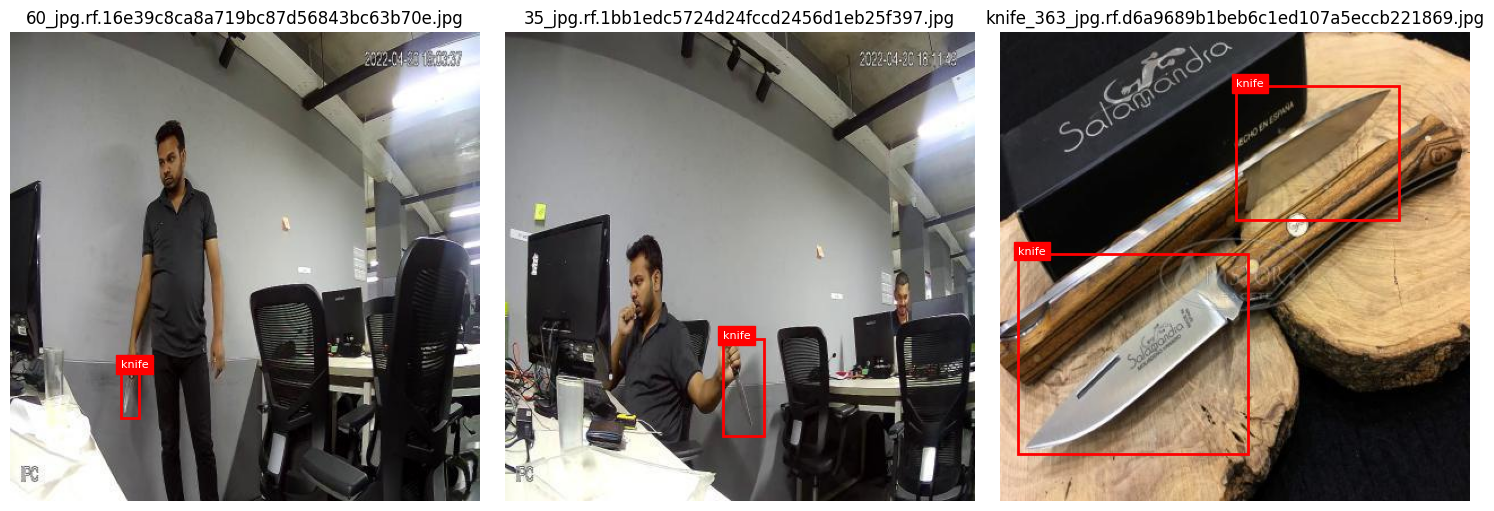

In [7]:
# Visualizar algumas imagens do conjunto de treino
train_images_dir = dataset_path / 'train' / 'images'
train_labels_dir = dataset_path / 'train' / 'labels'

print("Amostras do conjunto de treinamento:")
show_random_image_with_annotation(train_images_dir, train_labels_dir, n_samples=3)

## Treinamento do Modelo YOLOv11

Vamos treinar o modelo YOLOv11 utilizando o dataset existente.

In [9]:
def train_yolov11(data_yaml: Path, epochs: int = 50, img_size: int = 640, batch_size: int = 16, 
                  project: str = 'runs/train', name: str = 'exp', patience: int = 15) -> Path:
    """Treina o modelo YOLOv11 utilizando o dataset especificado."""
    
    # Verificamos se o arquivo data.yaml existe
    if not data_yaml.exists():
        raise FileNotFoundError(f"Arquivo data.yaml não encontrado: {data_yaml}")
    
    _device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Usando dispositivo: {_device}")
    # Inicializa o modelo YOLOv11 a partir do modelo pré-treinado
    model = YOLO('yolo11n.pt')  # Use 'yolov11n.pt' para um modelo menor e mais rápido
    model.to(_device)
    
    # Define os parâmetros de treinamento
    training_args = {
        'data': str(data_yaml),
        'epochs': epochs,
        'imgsz': img_size,
        'batch': batch_size,
        'project': project,
        'name': name,
        'patience': patience,  # Early stopping patience
        'verbose': True
    }
    
    # Executa o treinamento
    logging.info(f"Iniciando treinamento do YOLOv11 com {epochs} épocas, tamanho de imagem {img_size}")
    results = model.train(**training_args)
    
    # Retorna o caminho para o diretório de resultados do treinamento
    return Path(f"{project}/{name}")

In [10]:
# Defina os parâmetros de treinamento
current_directory = os.getcwd()
data_yaml_path = Path(f'{current_directory}\dataset\data.yaml')
epochs = 30  # Reduza para testar mais rapidamente se necessário
img_size = 640  # Tamanho padrão para YOLOv11
batch_size = 16  # Ajuste conforme capacidade da GPU

# Execute o treinamento
try:
    train_results_dir = train_yolov11(
        data_yaml=data_yaml_path, 
        epochs=epochs,
        img_size=img_size,
        batch_size=batch_size,
        project='runs/train',
        name='yolov11_knife_detection'
    )
    print(f"Treinamento concluído! Resultados salvos em: {train_results_dir}")
except Exception as e:
    logging.error(f"Erro durante o treinamento: {e}")

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_18672\3264547508.py:3: SyntaxWarning: invalid escape sequence '\d'
  data_yaml_path = Path(f'{current_directory}\dataset\data.yaml')
INFO: Iniciando treinamento do YOLOv11 com 30 épocas, tamanho de imagem 640


Usando dispositivo: cuda
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\data.yaml, epochs=30, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=runs/train, name=yolov11_knife_detection10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning C:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\train\labels.cache... 2893 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2893/2893 [00:00<?, ?it/s]
val: Scanning C:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\valid\labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]


Plotting labels to runs\train\yolov11_knife_detection10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\yolov11_knife_detection10
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.18G      1.893      3.091      1.778         24        640: 100%|██████████| 181/181 [00:27<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.15it/s]

                   all        797        849      0.287      0.298      0.205       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.81G      2.056      2.612      1.914         20        640: 100%|██████████| 181/181 [00:23<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


                   all        797        849      0.186      0.184      0.085     0.0279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.82G      2.075      2.411      1.968         28        640: 100%|██████████| 181/181 [00:23<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


                   all        797        849      0.342      0.241      0.208     0.0779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.83G      2.024      2.278      1.936         20        640: 100%|██████████| 181/181 [00:22<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]


                   all        797        849      0.459      0.418      0.385      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.85G      1.953      2.122      1.869         25        640: 100%|██████████| 181/181 [00:23<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.90it/s]


                   all        797        849      0.447      0.386      0.351      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.85G      1.874      2.016      1.825         27        640: 100%|██████████| 181/181 [00:23<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.83it/s]


                   all        797        849      0.595       0.48      0.525      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.85G      1.806      1.864      1.759         19        640: 100%|██████████| 181/181 [00:23<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


                   all        797        849      0.623      0.539      0.576      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.85G      1.801      1.789      1.743         21        640: 100%|██████████| 181/181 [00:23<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.88it/s]


                   all        797        849      0.722      0.551      0.625      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.85G      1.767      1.697      1.724         18        640: 100%|██████████| 181/181 [00:23<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.94it/s]

                   all        797        849      0.667      0.561      0.633      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.85G      1.732      1.602      1.674         25        640: 100%|██████████| 181/181 [00:22<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.93it/s]


                   all        797        849      0.748      0.641      0.723      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.85G      1.711      1.593      1.682         19        640: 100%|██████████| 181/181 [00:23<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.75it/s]

                   all        797        849      0.717      0.608      0.677       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.85G      1.675      1.503      1.637         24        640: 100%|██████████| 181/181 [00:23<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.70it/s]

                   all        797        849      0.788      0.577      0.692      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.85G      1.653      1.473      1.622         18        640: 100%|██████████| 181/181 [00:23<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.75it/s]

                   all        797        849      0.772       0.68      0.756      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.85G      1.619      1.423      1.596         28        640: 100%|██████████| 181/181 [00:23<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.85it/s]

                   all        797        849      0.787      0.706      0.783      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.85G      1.595      1.355      1.573         23        640: 100%|██████████| 181/181 [00:23<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.86it/s]

                   all        797        849      0.767      0.706      0.765      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.85G      1.586      1.342      1.569         24        640: 100%|██████████| 181/181 [00:23<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.88it/s]

                   all        797        849      0.837      0.731      0.817      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.85G      1.581      1.326      1.557         23        640: 100%|██████████| 181/181 [00:23<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.81it/s]

                   all        797        849      0.823       0.76      0.822       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.85G      1.534      1.296      1.527         19        640: 100%|██████████| 181/181 [00:23<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.87it/s]

                   all        797        849      0.856      0.734      0.838      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.85G      1.528      1.261      1.519         21        640: 100%|██████████| 181/181 [00:23<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.86it/s]

                   all        797        849      0.877      0.749      0.847      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.85G      1.495      1.219      1.492         22        640: 100%|██████████| 181/181 [00:23<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.89it/s]

                   all        797        849      0.853      0.751      0.832       0.45


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.85G      1.495     0.9959      1.528         17        640: 100%|██████████| 181/181 [00:23<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.77it/s]

                   all        797        849      0.866      0.755      0.845      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.85G      1.446     0.9457      1.498         13        640: 100%|██████████| 181/181 [00:22<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.01it/s]

                   all        797        849      0.855       0.79       0.85      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.85G      1.425     0.8928      1.484         13        640: 100%|██████████| 181/181 [00:22<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.96it/s]

                   all        797        849      0.884      0.811      0.871      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.85G       1.41     0.8634      1.467         13        640: 100%|██████████| 181/181 [00:22<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.03it/s]

                   all        797        849      0.863      0.811      0.868        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.85G      1.386     0.8336       1.44         13        640: 100%|██████████| 181/181 [00:22<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.00it/s]

                   all        797        849      0.884       0.81      0.883      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.85G      1.352     0.8093      1.426         13        640: 100%|██████████| 181/181 [00:22<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.98it/s]

                   all        797        849      0.876       0.82      0.887       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.85G      1.321     0.7737      1.399         13        640: 100%|██████████| 181/181 [00:22<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.95it/s]

                   all        797        849      0.892       0.84      0.899      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.85G      1.299       0.76       1.38         14        640: 100%|██████████| 181/181 [00:22<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.02it/s]

                   all        797        849       0.89      0.833      0.904      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.85G      1.285      0.731      1.371         13        640: 100%|██████████| 181/181 [00:22<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.01it/s]

                   all        797        849      0.875      0.851      0.908      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.85G      1.249     0.7098      1.351         13        640: 100%|██████████| 181/181 [00:22<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  6.05it/s]

                   all        797        849      0.894      0.849      0.911       0.54



30 epochs completed in 0.239 hours.
Optimizer stripped from runs\train\yolov11_knife_detection10\weights\last.pt, 5.5MB
Optimizer stripped from runs\train\yolov11_knife_detection10\weights\best.pt, 5.5MB

Validating runs\train\yolov11_knife_detection10\weights\best.pt...
Ultralytics 8.3.109  Python-3.12.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.97it/s]


                   all        797        849      0.895      0.849      0.911       0.54
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\train\yolov11_knife_detection10
Treinamento concluído! Resultados salvos em: runs\train\yolov11_knife_detection


## Avaliação do Modelo

Vamos avaliar o desempenho do modelo usando o conjunto de validação.

In [19]:
def evaluate_model(model_path: Path, data_yaml: Path) -> Dict:
    """Avalia o desempenho do modelo YOLOv11 treinado."""
    
    # Carrega o modelo treinado
    model = YOLO(model_path)
    
    # Realiza a validação no conjunto de validação
    results = model.val(data=str(data_yaml))
    
    # Extrai métricas relevantes
    metrics = {
        'precision': results.box.maps[-1] if hasattr(results.box, 'maps') and len(results.box.maps) > 0 else 0,  # mAP@0.5
        'mAP50-95': results.box.map if hasattr(results.box, 'map') else 0,  # mAP@0.5:0.95
        'recall': results.box.mar if hasattr(results.box, 'mar') else 0  # Mean Average Recall
    }
    
    return metrics

In [ ]:
# Caminho para o melhor modelo treinado
best_model_path = Path('runs/train/yolov11_knife_detection/weights/best.pt')

# Se o modelo existir, avalie-o
if best_model_path.exists():
    metrics = evaluate_model(best_model_path, data_yaml_path)
    print("Métricas de avaliação:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
else:
    print(f"Modelo não encontrado em {best_model_path}")

Ultralytics 8.3.109  Python-3.12.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\valid\labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:06<00:00,  8.15it/s]



                   all        797        849      0.889      0.859      0.911       0.54
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val2
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val2
Métricas de avaliação:
precision: 0.5403
mAP50-95: 0.5403
recall: 0.0000
Métricas de avaliação:
precision: 0.5403
mAP50-95: 0.5403
recall: 0.0000


## Teste em Imagens

Vamos testar o modelo em algumas imagens do conjunto de teste.

In [13]:
def test_on_images(model_path: Path, test_images_dir: Path, conf_threshold: float = 0.25, n_samples: int = 3) -> None:
    """Testa o modelo em algumas imagens do conjunto de teste e visualiza os resultados."""
    
    if not test_images_dir.exists():
        logging.error(f"Diretório de imagens de teste não encontrado: {test_images_dir}")
        return
        
    # Carrega o modelo
    model = YOLO(model_path)
    
    # Lista as imagens no diretório de teste
    image_files = list(test_images_dir.glob('*.*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if not image_files:
        logging.warning(f"Nenhuma imagem encontrada em {test_images_dir}")
        return
        
    # Seleciona n_samples imagens aleatórias
    selected_images = random.sample(image_files, min(n_samples, len(image_files)))
    
    # Processa cada imagem selecionada
    fig, axes = plt.subplots(1, len(selected_images), figsize=(5*len(selected_images), 5))
    if len(selected_images) == 1:
        axes = [axes]  # Força axes a ser uma lista para processamento uniforme
        
    for i, img_path in enumerate(selected_images):
        # Executa a detecção
        results = model(img_path, conf=conf_threshold)
        
        # Obtém a imagem com as detecções já plotadas
        res_plotted = results[0].plot()
        
        # Adiciona a imagem ao subplot
        axes[i].imshow(res_plotted)
        axes[i].set_title(f"{img_path.name}")
        axes[i].axis('off')
        
        # Exibe informações sobre as detecções
        detections = results[0].boxes
        print(f"Imagem: {img_path.name} - {len(detections)} detecções")
        
    plt.tight_layout()
    plt.show()


image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\DSC_0034_JPG_jpg.rf.84d5c93fa5d853ad31236d24a3c1ab12.jpg: 640x640 2 knifes, 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Imagem: DSC_0034_JPG_jpg.rf.84d5c93fa5d853ad31236d24a3c1ab12.jpg - 2 detecções

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\knife_109_jpg.rf.9bee30df7f9ecd0a420399ca7e01ea30.jpg: 640x640 2 knifes, 12.3ms
Speed: 3.6ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Imagem: knife_109_jpg.rf.9bee30df7f9ecd0a420399ca7e01ea30.jpg - 2 detecções

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\132_jpg.rf.00d080b1e1e7519912346b64b00614a7.jpg: 640x640 1 knife, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Imagem: 132_jpg.rf.00d080b1e1e7519912346b64b00614a7.jpg - 1 detecções

image 1/1 c:\Projec

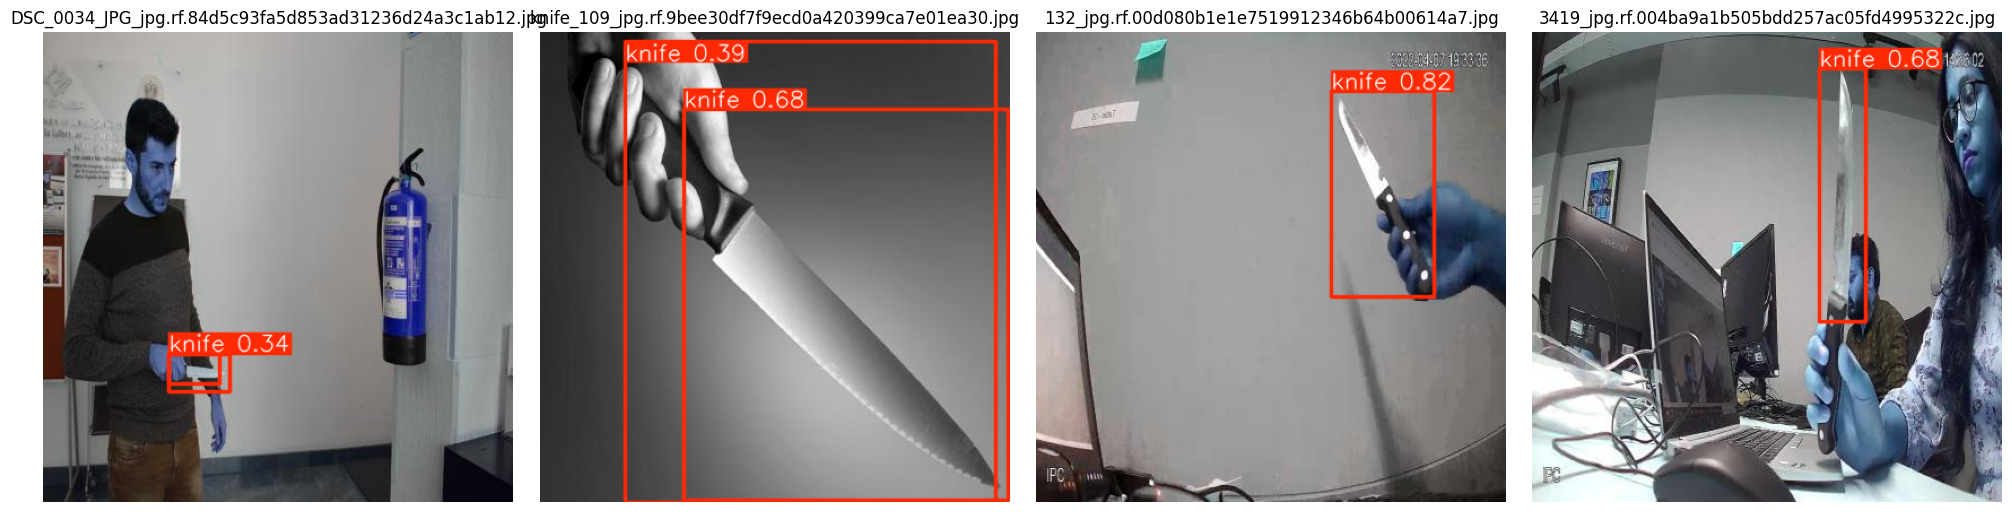

In [14]:
# Caminho para o diretório de imagens de teste
test_images_dir = Path('./dataset/test/images')

# Se o modelo existir, teste-o em algumas imagens
if best_model_path.exists():
    test_on_images(best_model_path, test_images_dir, conf_threshold=0.25, n_samples=4)
else:
    print(f"Modelo não encontrado em {best_model_path}")

## Teste em Vídeos

Vamos processar vídeos para detectar facas em cada frame.

In [15]:
def process_video(model_path: Path, video_path: Path, output_dir: Path, conf_threshold: float = 0.25) -> Path:
    """Processa um vídeo para detectar facas em cada frame."""
    
    if not video_path.exists():
        logging.error(f"Vídeo não encontrado: {video_path}")
        return None
        
    # Cria o diretório de saída se não existir
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Caminho para o vídeo de saída
    output_path = output_dir / f"{video_path.stem}_analyzed{video_path.suffix}"
    
    # Carrega o modelo
    model = YOLO(model_path)
    
    # Processa o vídeo
    logging.info(f"Processando vídeo: {video_path.name}")
    results = model.predict(
        source=str(video_path),
        conf=conf_threshold,
        save=True,
        project=str(output_dir.parent),
        name=output_dir.name,
        exist_ok=True
    )
    
    # Retorna o caminho para o vídeo processado (calculando onde o YOLO salva por padrão)
    processed_video = output_dir / f"{video_path.name}"
    if processed_video.exists():
        return processed_video
    return None

In [16]:
# Caminho para o diretório de vídeos
videos_dir = Path('./videos')
output_dir = Path('./output_videos')

# Lista os vídeos disponíveis
if videos_dir.exists():
    video_files = list(videos_dir.glob('*.mp4'))
    
    if video_files:
        # Se o modelo existir, processa os vídeos
        if best_model_path.exists():
            for video_path in video_files:
                processed_video = process_video(best_model_path, video_path, output_dir, conf_threshold=0.25)
                if processed_video:
                    print(f"Vídeo processado: {processed_video}")
        else:
            print(f"Modelo não encontrado em {best_model_path}")
    else:
        print(f"Nenhum vídeo encontrado em {videos_dir}")
else:
    print(f"Diretório de vídeos não encontrado: {videos_dir}")

INFO: Processando vídeo: video.mp4




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 47.7ms
video 1/1 (frame 2/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 10.1ms
video 1/1 (frame 3/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 12.9ms
video 1/1 (frame 4/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (n

INFO: Processando vídeo: video2.mp4




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks 

## Sistema de Alerta

Mantemos a funcionalidade de envio de alertas quando facas são detectadas.

In [21]:
def generate_video_detection_summary(model_path: Path, videos_dir: Path, conf_threshold: float = 0.25) -> str:
    """Gera um resumo detalhado das detecções nos vídeos."""
    
    if not model_path.exists():
        return "Modelo não encontrado."
        
    if not videos_dir.exists():
        return "Diretório de vídeos não encontrado."
    
    # Lista os vídeos disponíveis
    video_files = list(videos_dir.glob('*.mp4'))
    if not video_files:
        return "Nenhum vídeo encontrado."
    
    # Carrega o modelo
    model = YOLO(model_path)
    
    summary = ""
    
    # Analisa cada vídeo
    for video_idx, video_path in enumerate(video_files, 1):
        # Realiza as predições frame por frame sem salvar o vídeo
        results = model.predict(source=str(video_path), conf=conf_threshold, stream=True)
        
        total_frames = 0
        frames_with_knife = 0
        frames_without_knife = 0
        total_knives = 0
        
        # Analisa cada frame
        for frame_idx, result in enumerate(results):
            total_frames += 1
            detections = result.boxes
            
            if len(detections) > 0:
                frames_with_knife += 1
                total_knives += len(detections)
            else:
                frames_without_knife += 1
        
        # Adiciona o resumo deste vídeo
        video_summary = f"Video {video_idx}: {video_path.name}\n"
        video_summary += f"- Número de frames analisados: {total_frames}\n"
        video_summary += f"- Número de frames onde facas foram detectadas: {frames_with_knife}\n"
        video_summary += f"- Número de frames sem facas: {frames_without_knife}\n"
        video_summary += f"- Número total de facas detectadas: {total_knives}\n\n"
        
        summary += video_summary
        logging.info(f"Análise concluída para o vídeo {video_path.name}")
    
    return summary

In [22]:
def send_alert_via_webhook(summary: str, recipient_email: str, webhook_url: str) -> None:
    """Envia um alerta via webhook quando facas são detectadas."""
    
    payload = {
        "email": recipient_email,
        "summary": summary
    }
    
    try:
        response = requests.post(webhook_url, json=payload)
        if response.ok:
            logging.info("Alerta enviado com sucesso!")
        else:
            logging.error(f"Erro ao enviar alerta: {response.status_code} - {response.text}")
    except Exception as e:
        logging.error(f"Exceção ao enviar alerta: {e}")

In [23]:
def generate_detection_summary(model_path: Path, test_dir: Path, conf_threshold: float = 0.25) -> str:
    """Gera um resumo das detecções no diretório de teste."""
    
    if not test_dir.exists():
        return "Diretório de teste não encontrado."
    
    # Carrega o modelo
    model = YOLO(model_path)
    
    # Lista as imagens de teste
    test_images = list(test_dir.glob('*.*'))
    test_images = [img for img in test_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if not test_images:
        return "Nenhuma imagem encontrada no diretório de teste."
        
    total_images = len(test_images)
    images_with_knife = 0
    total_knives = 0
    
    # Processa cada imagem
    for img_path in test_images:
        results = model(img_path, conf=conf_threshold)
        detections = results[0].boxes
        
        if len(detections) > 0:
            images_with_knife += 1
            total_knives += len(detections)
    
    # Gera o resumo
    summary = f"Das {total_images} imagens testadas, foram encontradas facas em {images_with_knife} imagens, "
    summary += f"totalizando {total_knives} facas detectadas. "
    summary += f"Em {total_images - images_with_knife} imagens, nenhuma faca foi encontrada."
    
    return summary

In [24]:
def save_summary_to_file(summary: str, output_path: Path) -> None:
    """Salva o resumo das detecções em um arquivo de texto."""
    
    # Garante que o diretório pai exista
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Escreve o resumo no arquivo
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(summary)
    
    logging.info(f"Resumo salvo em: {output_path}")

In [25]:
# Processamento e geração de summaries para vídeos e imagens de teste
if best_model_path.exists():
    # Gerar e salvar summary de imagens de teste
    if test_images_dir.exists():
        test_images_summary = generate_detection_summary(best_model_path, test_images_dir)
        test_images_summary_path = Path('./summary_test_images.txt')
        save_summary_to_file(test_images_summary, test_images_summary_path)
        print(f"Summary das imagens de teste salvo em: {test_images_summary_path}")
    
    # Gerar e salvar summary de vídeos
    if videos_dir.exists():
        videos_summary = generate_video_detection_summary(best_model_path, videos_dir)
        videos_summary_path = Path('./summary_videos.txt')
        save_summary_to_file(videos_summary, videos_summary_path)
        print(f"Summary dos vídeos salvo em: {videos_summary_path}")
        
        # Configurar o envio do alerta apenas com o summary dos vídeos
        recipient_email = "joao.mamprin@gruposf.com.br"  # Substitua pelo e-mail desejado
        webhook_url = "https://hook.us2.make.com/bmjkujkyahk1qfbapdbwy2mjic80fi6d"
        
        print("\nResumo dos vídeos analisados (será enviado por e-mail):")
        print(videos_summary)
        
        # Descomente a linha abaixo para enviar o alerta com apenas o summary dos vídeos
        # send_alert_via_webhook(videos_summary, recipient_email, webhook_url)
else:
    print(f"Modelo não encontrado em {best_model_path}")


image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\101_jpg.rf.2329d2c590261bcfb98922d685025e01.jpg: 640x640 2 knifes, 21.7ms
Speed: 3.3ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\101_jpg.rf.2329d2c590261bcfb98922d685025e01.jpg: 640x640 2 knifes, 21.7ms
Speed: 3.3ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\104_jpg.rf.d4393558d0fd81e36b486d6f736279eb.jpg: 640x640 1 knife, 24.2ms
Speed: 3.5ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\dataset\test\images\104_jpg.rf.d4393558d0fd81e36b486d6f736279eb.jpg: 640x640 1 knife, 24.2ms
Speed: 3.5ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\

INFO: Resumo salvo em: summary_test_images.txt


Summary das imagens de teste salvo em: summary_test_images.txt


video 1/1 (frame 1/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 2/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 1/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 2/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 3/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 10.3ms
video 1/1 (frame 4/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 9.5ms
video 1/1 (frame 3/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 (no detections), 10.3ms
video 1/1 (frame 4/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video.mp4: 384x640 

INFO: Análise concluída para o vídeo video.mp4



video 1/1 (frame 1/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 2 knifes, 14.7ms
video 1/1 (frame 2/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 2 knifes, 9.8ms
video 1/1 (frame 1/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 2 knifes, 14.7ms
video 1/1 (frame 2/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 2 knifes, 9.8ms
video 1/1 (frame 3/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 1 knife, 11.9ms
video 1/1 (frame 4/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 (no detections), 11.4ms
video 1/1 (frame 3/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 1 knife, 11.9ms
video 1/1 (frame 4/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x640 (no detections), 11.4ms
video 1/1 (frame 5/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\Hackaton\videos\video2.mp4: 384x64

INFO: Análise concluída para o vídeo video2.mp4
INFO: Resumo salvo em: summary_videos.txt
INFO: Resumo salvo em: summary_videos.txt


Summary dos vídeos salvo em: summary_videos.txt

Resumo dos vídeos analisados (será enviado por e-mail):
Video 1: video.mp4
- Número de frames analisados: 1264
- Número de frames onde facas foram detectadas: 396
- Número de frames sem facas: 868
- Número total de facas detectadas: 567

Video 2: video2.mp4
- Número de frames analisados: 39
- Número de frames onde facas foram detectadas: 11
- Número de frames sem facas: 28
- Número total de facas detectadas: 15




## Conclusão

Neste notebook, implementamos um sistema completo de detecção de facas usando o YOLOv11, desde o treinamento até o teste em imagens e vídeos.

Principais etapas realizadas:
1. Exploração e visualização do dataset existente
2. Treinamento do modelo YOLOv11 usando a biblioteca ultralytics
3. Avaliação do modelo usando métricas padrão
4. Teste em imagens e vídeos
5. Implementação do sistema de alertas

As vantagens do YOLOv11 sobre o YOLOv5 incluem melhorias na precisão de detecção, velocidade de inferência e capacidade de detectar objetos menores.